In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:.5f}'.format

import copy
import cv2
import os
import math
import scipy as sp
import PIL

# Tensorflow
import tensorflow as tf
from tensorflow.keras import models, layers, Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten, Dense, Dropout, ZeroPadding2D

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import EfficientNetB4, EfficientNetB6, ResNet50V2
#from keras_tuner.tuners import RandomSearch

import scikitplot as skplt
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# split dataset
import splitfolders

# ignore warnings
import warnings
warnings.filterwarnings(action='ignore')




In [10]:
pear= '/Users/krc/Downloads/01_YS_folder/fruit_fire/image/train/Train/'


In [11]:
# 부위 별
Train_x = []
Train_y = []
    

for FileName in os.listdir(pear + '00_배정상/'):
    temp = copy.deepcopy(PIL.Image.open(pear + '00_배정상/' + FileName))
    Train_x.append(temp)
    Train_y.append(0)
    
for FileName in os.listdir(pear + '01_배검은별무늬병/'):
    temp = copy.deepcopy(PIL.Image.open(pear + '01_배검은별무늬병/' + FileName))
    Train_x.append(temp)
    Train_y.append(1)

for FileName in os.listdir(pear + '02_배과수화상병/'):
    temp = copy.deepcopy(PIL.Image.open(pear + '02_배과수화상병/' + FileName))
    Train_x.append(temp)
    Train_y.append(2)

        

In [12]:
Train_x = np.stack(Train_x, axis=0 )
Train_y = np.array(Train_y)
print(Train_x.shape) # RGB
print(Train_y.shape)

(22991, 224, 224, 3)
(22991,)


In [13]:
pear1 = '/Users/krc/Downloads/01_YS_folder/fruit_fire/image/test/Test/'

In [14]:
Test_x = []
Test_y = []

for FileName in os.listdir(pear1 + '00_배정상/'):
    temp = copy.deepcopy(PIL.Image.open(pear1 + '00_배정상/' + FileName))
    Test_x.append(temp)
    Test_y.append(0)
    
for FileName in os.listdir(pear1 + '01_배검은별무늬병/'):
    temp = copy.deepcopy(PIL.Image.open(pear1 + '01_배검은별무늬병/' + FileName))
    Test_x.append(temp)
    Test_y.append(1)

for FileName in os.listdir(pear1 + '02_배과수화상병/'):
    temp = copy.deepcopy(PIL.Image.open(pear1 + '02_배과수화상병/' + FileName))
    Test_x.append(temp)
    Test_y.append(2)


In [15]:
Test_x = np.stack(Test_x, axis=0 )
Test_y = np.array(Test_y)
print(Test_x.shape) # RGB
print(Test_y.shape)

(2879, 224, 224, 3)
(2879,)


In [17]:
mobilenet_model = tf.keras.applications.mobilenet_v2.MobileNetV2(include_top=False,  weights="imagenet",input_shape=(224,224,3,))


In [18]:
# batch_size: 한번에 forward & Backword 하는 샘플의 수
batch_size = 32

# Training 수
epochs = 50

# Weight 조절 parameter
LearningRate = 1e-3 # 0.001
Decay = 1e-6

img_width = 224
img_height = 224

a = mobilenet_model.layers[-1].output
x = tf.keras.layers.GlobalAveragePooling2D()(a)
predictions = Dense(3, activation='softmax')(x)

# Input ~ Output 연결해주기
DeepLearning = Model(inputs = mobilenet_model.input, outputs=predictions)

# learning parameter를 더하여 최종 model compile
DeepLearning.compile(optimizer=
         SGD(lr=LearningRate, decay=Decay, momentum=0.9, nesterov=True), 
         loss='categorical_crossentropy',
         metrics=['acc'])

In [19]:
train_directory = '/Users/krc/Downloads/01_YS_folder/fruit_fire/image/train/Train/'
test_directory  = '/Users/krc/Downloads/01_YS_folder/fruit_fire/image/test/Test/'
model_directory = '/Users/krc/Downloads/01_YS_folder/fruit_fire/image/model/'
tensorboard_directory = '/Users/krc/Downloads/01_YS_folder/fruit_fire/image/' + 'Tensorboard'

In [20]:
DATAGEN_TRAIN = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    featurewise_center=True,
    featurewise_std_normalization=True,
    data_format="channels_last",
    validation_split=0.10) # Train / Validation

# Online-augmentation 비적용 Generator (Test용)
DATAGEN_TEST = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    data_format="channels_last")

In [22]:
# Generator의 instance 생성 (Train)
TRAIN_GENERATOR = DATAGEN_TRAIN.flow_from_directory(
    train_directory,
    classes=["00_배정상","01_배검은별무늬병","02_배과수화상병"],
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode= "categorical", # sigmoid
    subset = "training")

VALID_GENERATOR = DATAGEN_TRAIN.flow_from_directory(
    train_directory,
    classes=["00_배정상", "01_배검은별무늬병","02_배과수화상병"],
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode="categorical",
    subset = "validation")

# Generator의 instance 생성 (Test)
TEST_GENERATOR = DATAGEN_TEST.flow_from_directory(
    test_directory,
    classes=["00_배정상", "01_배검은별무늬병","02_배과수화상병"],
    target_size = (img_width, img_height),
    batch_size = batch_size,
    shuffle = False,
    class_mode='categorical')


# sigmoid / binary / binary_crossentropy
# softmax / categorical / categorical_crossentropy

Found 20693 images belonging to 3 classes.
Found 2298 images belonging to 3 classes.
Found 2879 images belonging to 3 classes.


In [23]:
CP = ModelCheckpoint(filepath=model_directory+'mobilenet-{epoch:03d}-{val_loss:.4f}-{val_acc:.4f}.hdf5',
            monitor='val_acc', verbose=1, save_best_only=True, mode='max')
TB = TensorBoard(log_dir=tensorboard_directory, write_graph=True, write_images=True)
LR = ReduceLROnPlateau(monitor='val_loss',factor=0.8,patience=3, verbose=1, min_lr=1e-8)

CALLBACK = [CP, TB, LR]

In [24]:
DeepLearning.fit(
        TRAIN_GENERATOR,
        steps_per_epoch=TRAIN_GENERATOR.n / batch_size,
        epochs=10,
        callbacks=CALLBACK,
        shuffle=True, 
        validation_data=VALID_GENERATOR)

Epoch 1/10


2022-07-28 13:58:08.272695: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


647/646 [==============================] - ETA: 0s - loss: 0.1114 - acc: 0.9625
Epoch 1: val_acc improved from -inf to 0.93951, saving model to /Users/krc/Downloads/01_YS_folder/fruit_fire/image/model/mobilenet-001-0.1749-0.9395.hdf5
646/646 [==============================] - 820s 1s/step - loss: 0.1114 - acc: 0.9625 - val_loss: 0.1749 - val_acc: 0.9395 - lr: 0.0010
Epoch 2/10
647/646 [==============================] - ETA: 0s - loss: 0.0457 - acc: 0.9842
Epoch 2: val_acc improved from 0.93951 to 0.96649, saving model to /Users/krc/Downloads/01_YS_folder/fruit_fire/image/model/mobilenet-002-0.0899-0.9665.hdf5
646/646 [==============================] - 797s 1s/step - loss: 0.0457 - acc: 0.9842 - val_loss: 0.0899 - val_acc: 0.9665 - lr: 0.0010
Epoch 3/10
647/646 [==============================] - ETA: 0s - loss: 0.0355 - acc: 0.9880
Epoch 3: val_acc improved from 0.96649 to 0.96910, saving model to /Users/krc/Downloads/01_YS_folder/fruit_fire/image/model/mobilenet-003-0.0787-0.9691.hdf5


KeyboardInterrupt: 

In [25]:
DeepLearning.load_weights('/Users/krc/Downloads/01_YS_folder/fruit_fire/image/model/mobilenet-006-0.0761-0.9739.hdf5')

In [26]:
TEST_Prediction = DeepLearning.predict_generator(TEST_GENERATOR, verbose=1)

90/90 [==============================] - 20s 217ms/step


In [27]:
Result = pd.DataFrame(TEST_Prediction)
Result

,0,1,2
0,0.27656,0.16258,0.56086
1,0.02844,0.00004,0.97151
2,0.29831,0.00006,0.70163
3,0.94996,0.02883,0.02121
4,0.87343,0.01485,0.11172
...,...,...,...
2874,0.00039,0.00000,0.99961
2875,0.01321,0.01415,0.97264
2876,0.00024,0.00000,0.99975
2877,0.00020,0.00003,0.99976


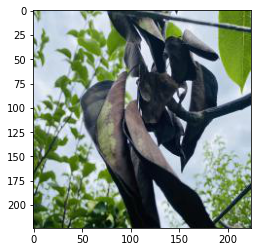

02V006_80_1_02_01_03_22_3_9177r_20200918_29.jpg
업로드한 사진과 유사한 이미지는 99.999985% 확률로 배과수화상병입니다.




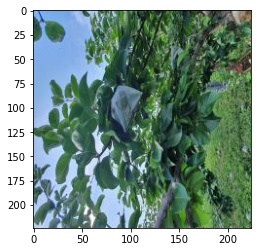

02V006_80_1_02_01_03_23_3_3162y_20201127_10.jpg
업로드한 사진과 유사한 이미지는 99.915985% 확률로 배과수화상병입니다.




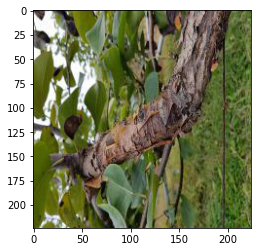

02V006_80_1_02_01_04_23_3_2493r_20201128_5.jpg
업로드한 사진과 유사한 이미지는 96.62239% 확률로 배과수화상병입니다.




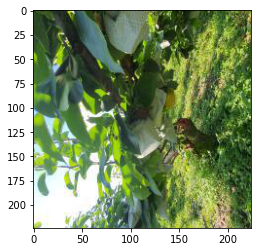

02V006_80_1_02_01_03_23_3_4596y_20201022_1.jpg
업로드한 사진과 유사한 이미지는 99.989105% 확률로 배과수화상병입니다.




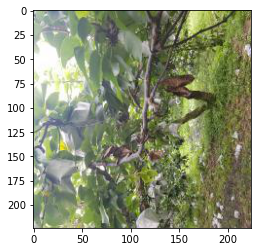

02V006_80_1_02_01_04_23_3_1335y_20201110_3.jpg
업로드한 사진과 유사한 이미지는 99.96383% 확률로 배과수화상병입니다.




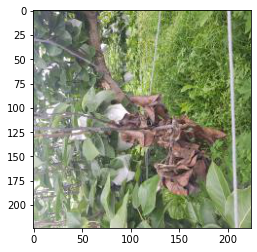

02V006_80_1_02_01_03_23_3_1335y_20201019_8.jpg
업로드한 사진과 유사한 이미지는 99.9914% 확률로 배과수화상병입니다.




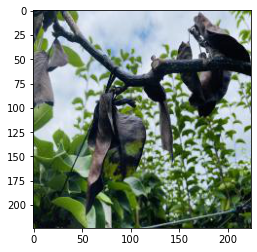

02V006_80_1_02_01_03_22_3_2370b_20200918_30.jpg
업로드한 사진과 유사한 이미지는 99.99994% 확률로 배과수화상병입니다.




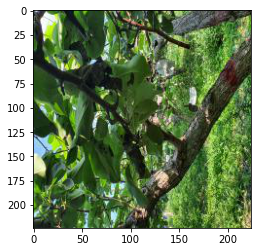

02V006_80_1_02_01_03_22_3_0325y_20200923_8.jpg
업로드한 사진과 유사한 이미지는 99.5033% 확률로 배과수화상병입니다.




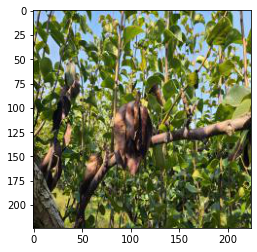

02V006_80_1_02_01_05_23_3_9177r_20201023_2.jpg
업로드한 사진과 유사한 이미지는 99.97636% 확률로 배과수화상병입니다.




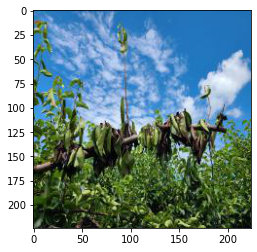

02V006_80_1_02_01_03_23_3_4142r_20200921_1.jpg
업로드한 사진과 유사한 이미지는 99.83962% 확률로 배과수화상병입니다.




In [68]:
from keras.models import load_model
from PIL import Image, ImageOps
import numpy as np
import pandas as pd
import itertools
import random

model = load_model('/Users/krc/Downloads/01_YS_folder/fruit_fire/image/model/mobilenet-006-0.0761-0.9739.hdf5')
fruit = ['정상 배','배검은별무늬병','배과수화상병']
path = '/Users/krc/Downloads/01_YS_folder/fruit_fire/image/test/Test/02_배과수화상병/'
# for FileName in os.listdir(path):
for i in range(10):
    FileName=random.choice(os.listdir(path))
    data = np.ndarray(shape=(1, 224, 224, 3), dtype=np.float32)
    img = copy.deepcopy(PIL.Image.open(path + FileName))
    img = ImageOps.fit(img, (224, 224), Image.ANTIALIAS)
    normalized_image_array = np.asarray(img, dtype = 'float32') / 255.
    plt.imshow(normalized_image_array)
    plt.show()
    
    data[0] = normalized_image_array
    result = (model.predict(data))*100
    result1 = pd.DataFrame(result)
    a= result.tolist()
    a.sort()
    print(FileName)
    for i in range(len(result[0])) :
        if result[0][i] > 40:
            a = result[0][i]
            a = a.astype(str)
            print("업로드한 사진과 유사한 이미지는 " + a + "% 확률로 " + fruit[i] + "입니다.")
            print('\n')